Population

# Preload

In [39]:
import urllib.request, urllib.parse, urllib.error
import requests
from bs4 import BeautifulSoup

import lxml
import re
import os
import time
import datetime
import chardet
import zipfile
from zipfile import ZipFile
import json
from io import BytesIO

from IPython.display import display

import matplotlib.pyplot as plt
import matplotlib.transforms
%matplotlib inline

import folium
from PIL import Image


import numpy as np
import pandas as pd

pd.set_option('precision', 4)
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)
pd.set_option('max_colwidth',100)

def curl(url,path,mode='wb'):
    response = urllib.request.urlopen(url).read()
    with open(path, mode) as handle:
        handle.write(response)

In [2]:
"""小写开头的字母用于临时变量"""

# data -- 用于创建表格的临时数据，创建完后必须赋值给永久变量
# df   -- 用于画图的临时数据，画图时将所需数据赋值给它
# dfs  -- 用于画图的临时数据字典，画图时将所需数据赋值给它
# domain
# 其他小写字母


"""初始化全局变量，请小心操作"""

# 用户自定义参数，会随着用户设置的变化而变化
D = ''    # Domain
A = ''    # Area     单一的国家/地区，
As = []
E = ''    # Element
Es = []
I = ''    # A paticular Item
Is = []   # Items

# 根据用户变量生成
DFs = {}        # 每个 Domain 的所有数据是一份 DF，keys=Domains，no index, columns=['Area Code', 'Area', 'Element', 'Item', 'Year', 'Unit', 'Value']
CDTs = {}       # 从DFs筛选数据的条件，key0=Domain, key1=Area, key2=Element, value=Items
PVs_AreaYear = {}        # 从DFs根据筛选条件生成的 DICT, key0=Domain, key1=Area, key2=Element, key3=Items, values=DF, index=Areas, columns=Years
PVs_YearArea = {}        # 从DFs根据筛选条件生成的 DICT, key0=Domain, key1=Area, key2=Element, key3=Items, values=DF, index=Years, columns=Areas

Years = []      # 年份列表

PVs_AG = {}     # 某国家地区与其所在组合的某些 Items 的比较，key0=Domain, key1=Area, key2=Element, key3=[AG, A, G], index=Years, columns=[C,G]

# 必要的信息 
DOMs = {}        # Domain 的描述字典， key=domain_name(file name's pref)
LIST_countries=[]  # 国家级地区列表，Area Code < 5000, default refer to  worlds contries
LIST_groups=[]    # 地区组合列表，Area Code >= 5000, default grouped by continents


""" DIRECTOR SETTINGS"""

FAO_DOWNLOADS_ROOT = 'http://fenixservices.fao.org/faostat/static/bulkdownloads/'
FAO_DOWNLOADS_XML = os.path.join(FAO_DOWNLOADS_ROOT, 'datasets_E.xml')
FAO_DOWNLOADS_JSON = os.path.join(FAO_DOWNLOADS_ROOT, 'datasets_E.json')
FAO_DOWNLOADS_BULK = os.path.join(FAO_DOWNLOADS_ROOT, 'FAOSTAT.zip')

print(f'FAOSTAT downloads root: {FAO_DOWNLOADS_ROOT}')
print(f'FAOSTAT description in .xml: {FAO_DOWNLOADS_XML}')
print(f'FAOSTAT description in .json: {FAO_DOWNLOADS_JSON}')
print(f'FAOSTAT downloads .zip: {FAO_DOWNLOADS_BULK}')

# what is the relevent path of root
root_where = '../../'
print('+++++++++ Atention ++++++++++')
print(f'The root is set as "{root_where}" relevent to this file.' )
print(f'If it is not right, you change this parameter where the parameter name is "root_where".' )
print('+++++++++++++++++++++++++++++')

LOCAL_ROOT = os.path.abspath(root_where)

DATA_BASE = os.path.join(LOCAL_ROOT, 'data')
DATA_FAO = os.path.join(DATA_BASE, 'FAO')
DATA_NBS = os.path.join(DATA_BASE, 'NBS')
DATA_hybrids = os.path.join(DATA_BASE, 'hybrids')

FAO_meta = os.path.join(DATA_FAO, 'metadata')
FAO_description_path = FAO_meta + '/datasets_E.xml'
FAO_BULK_zip = DATA_FAO + '/FAOSTAT.zip'

print(f'Root director: {LOCAL_ROOT}')
print(f'Data director: {DATA_BASE}')
print(f'FAO data director: {DATA_FAO}')
print(f'NBS data director: {DATA_NBS}')
print(f'Datasets hybrids director: {DATA_hybrids}')
print(f'FAO metadata director: {FAO_meta}')
print(f'FAO local description file: {FAO_description_path}')
print(f'FAO local datasets zip: {FAO_BULK_zip}')

SUFFIX = '_E_All_Data_(Normalized)'  # suffix of fao data file name
print(f'Suffix of raw FAO data file name: {SUFFIX}')

FAOSTAT downloads root: http://fenixservices.fao.org/faostat/static/bulkdownloads/
FAOSTAT description in .xml: http://fenixservices.fao.org/faostat/static/bulkdownloads/datasets_E.xml
FAOSTAT description in .json: http://fenixservices.fao.org/faostat/static/bulkdownloads/datasets_E.json
FAOSTAT downloads .zip: http://fenixservices.fao.org/faostat/static/bulkdownloads/FAOSTAT.zip
+++++++++ Atention ++++++++++
The root is set as "../../" relevent to this file.
If it is not right, you change this parameter where the parameter name is "root_where".
+++++++++++++++++++++++++++++
Root director: /mnt/sda2/_hub/projects/GoodFood/meat-atlas
Data director: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/data
FAO data director: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/data/FAO
NBS data director: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/data/NBS
Datasets hybrids director: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/data/hybrids
FAO metadata director: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/

In [3]:
def FAO_description_dic(soup):
    """
    input soup parsed by bs4
    parse it to dict with nessesary info
    """
    dic = {}
    for dataset in soup.find_all('Dataset'):
        file_loc = dataset.FileLocation.string
        domain = file_loc[file_loc.find('bulkdownloads/')+len('bulkdownloads/'):file_loc.find('_E_All')]
        dic[domain] = {'DatasetCode': dataset.DatasetCode.string,
                        'DatasetName': dataset.DatasetName.string,
                        'Topic': dataset.Topic.string,
                        'DatasetDescription': dataset.DatasetDescription.string,
                        'MedaData': [dataset.Contact.string, dataset.Email.string, dataset.DateUpdate.string, dataset.CompressionFormat.string, dataset.FileType.string, dataset.FileSize.string, dataset.FileRows.string],
                        'Url_Normalized':dataset.FileLocation.string}
    return dic

In [4]:
""" If you need to update, uncomment this cell. """
# # Download or update FAOSTAT datasets if necessary
# if os.path.exists(FAO_description_path) or os.path.exists(FAO_BULK_zip): pass
# else: 
#     print('Need to download or update FAOSTAT datasets.')
#     print('Processing ...')
#     curl(url=FAO_DOWNLOADS_XML, path=FAO_description_path)
#     curl(url=FAO_DOWNLOADS_BULK, path=FAO_BULK_zip)
    
# # Check local datasets update  
# print('Checking updates ...')

# # local datasets
# print('Checking Local description ...')
# with open(FAO_description_path, 'rb') as handle:
#     xml = handle.read()
#     soup = BeautifulSoup(xml, 'xml')
# xml_local = FAO_description_dic(soup)

# # online datasets
# print('Checking latest description ...')
# response = requests.get(FAO_DOWNLOADS_XML)
# xml = response.content
# soup = BeautifulSoup(xml, 'xml')
# xml_online = FAO_description_dic(soup)

# # compare
# print('Comparing ...')
# shared_items = {k: xml_local[k] for k in xml_local if k in xml_online and xml_local[k] == xml_online[k]}
# need_update = {k: xml_local[k] for k in xml_local if xml_local[k] != xml_online[k]}
# update_to = {k: xml_local[k] for k in xml_local if xml_local[k] != xml_online[k]}

# print('No. of local datasets: ', len(xml_local))
# print('No. of latest datasets: ', len(xml_online))
# print('No. of shared datasets: ', len(shared_items))

# if len(xml_local)==len(shared_items) and len(xml_local)==len(xml_online):
#     print ('Already up to date.')
# else:
#     print('Need update: ', need_update)
#     print('Update to: ', update_to)
#     print("NOTE: If you don't concern about datasets listed above, there's no need to update!")
    
# print('Done succesfully.')

' If you need to update, uncomment this cell. '

In [5]:
with open(FAO_description_path, 'rb') as handle:
    xml = handle.read()
    soup = BeautifulSoup(xml, 'xml')
DOMs = FAO_description_dic(soup)
# display(DOMs)

# 加载国家列表
LIST_countries = []
with open(FAO_meta+'/list_countries_world.txt', 'r') as handle:
    for line in handle.readlines():
        line=line.strip()
        LIST_countries.append(line)
LIST_countries.remove('China')  # Because we use `China, mainland`
print(f'There are {len(LIST_countries)} countries.')
# display(LIST_countries)

# 加载区域/组合列表
LIST_groups = []
with open(FAO_meta+'/list_groups_world.txt', 'r') as handle:
    for line in handle.readlines():
        line=line.strip()
        LIST_groups.append(line)
COUNT_groups = len(LIST_groups)
print(f'There are {len(LIST_groups)} groups.')
# display(LIST_groups)

# 自定义常用区域/组合列表
# OECD
LIST_countries_OECD = []
with open(FAO_meta+'/list_countries_OECD.txt', 'r') as handle:
    for line in handle.readlines():
        line=line.strip()
        LIST_countries_OECD.append(line)
print(f'There are {len(LIST_countries_OECD)} OECD countries.')
# display(LIST_countries_OECD)

# Asia
LIST_countries_asia = []
with open(FAO_meta+'/list_countries_asia.txt', 'r') as handle:
    for line in handle.readlines():
        line=line.strip()
        LIST_countries_asia.append(line)
print(f'There are {len(LIST_countries_asia)} Asian countries.')
# display(LIST_countries_asia)

There are 225 countries.
There are 34 groups.
There are 36 OECD countries.
There are 53 Asian countries.


In [93]:
# plt.style.use(['ggplot'])

# fig size
FIG_size = (6, 3)
DPI = 300

# font size
TIT_size = 12    # titles
LAB_size = 10    # labels
LEG_size = 10    # legends
TCK_size = 10    # ticklabels

LIN_wei = 1.5    # line weights
BAR_wid = 3      # bar width

# GRD_wid = 0.5    # grid line width
# GRD_clr = 'white' 
# GRD_aph = 1     # grid alpha

CLs = ('#ffab91','#c62828','#689f38','#ff6f00','#8c9eff','#ffc400','#283593',
       'chocolate','r','orange','maroon','hotpink','b','yellowgreen','deepskyblue','g','c','lightslategray','k')

CLs_2 = ("#f57f17", "#b2dfdb")

MKs = ('o', 'x','o','x', 'v','.','v','.','o','x','o', 'x', 'v','.','v','.')
LSs = ('-','-','--', ':', ':','-.','-.','-','-','--','--', ':', ':','-.','-.')

# =============================================================================================================
def setX_quant(ax, ticks, step, label = ''):
    ax.set_xticks(ticks)
    ax.set_xlim(ticks[0]-step/2,ticks[-1]+step/2)
    ax.set_xticklabels(ticks, rotation=0, ha='center', fontsize=TCK_size)
    ax.set_xlabel(label, fontsize=LAB_size)
#     ax.xaxis.grid(True, linewidth=GRD_wid, color=GRD_clr, alpha=GRD_aph)
    
def setX_quali(ax, ticks, label = ''):
    ax.set_xticklabels(ticks, rotation=90, ha='center', fontsize=TCK_size)
    ax.set_xlabel(label, fontsize=LAB_size)
#     ax.xaxis.grid(True, linewidth=GRD_wid, color=GRD_clr, alpha=GRD_aph)

def setY_quant(ax, y_max, label = ''):
    tick_num = 9
    step = y_max/(tick_num-1)
    min_gap = 10
    
    if step < 1:
        step = round(step,1)
        dec=1
    elif step < 10:
        step = int(step)
        dec=0
    elif step/min_gap < 10:
        step = int(step/min_gap)*10
        dec=0
    else:
        n=0
        while step/min_gap >= 10:
            step = int(step/min_gap)
            n += 1
        step = int(step/min_gap)*(min_gap**(n+1))
        dec=0
        
    y_max = step*(tick_num+1)        
    ticks = np.round(np.arange(0, y_max+step, step),decimals=dec)
    ax.set_yticks(ticks)
    ax.set_ylim(ticks[0],ticks[-1]+step)
    ax.set_yticklabels(ticks, fontsize=TCK_size)
    ax.set_ylabel(label, fontsize=LAB_size) 
#     ax.yaxis.grid(True, linewidth=GRD_wid, color=GRD_clr, alpha=GRD_aph)
    
def setY_per(ax):
    ticks=np.round(np.linspace(0, 100, num=11, endpoint=True), decimals=0)
    ax.set_yticks(ticks)
    ax.set_ylim(ticks[0],ticks[-1])
    ax.set_yticklabels(ticks, fontsize=TCK_size)
    ax.set_ylabel('Percentage (%)', fontsize=LAB_size)
#     ax.yaxis.grid(True, linewidth=GRD_wid, color=GRD_clr, alpha=GRD_aph)

In [7]:
def rdDF(domain):
    
    display(DOMs[domain])
    
    zf = ZipFile(f'{DATA_FAO}/{domain}{SUFFIX}.zip')
    encodings = ["ISO-8859-1", "UTF-8", "UTF-8-SIG", "GBK"]
    for encoding in encodings:
        try:
            data = pd.read_csv(zf.open(f'{domain}{SUFFIX}.csv'), encoding="ISO-8859-1")
        except:
            pass
    
    display(data.head())
    display(data.tail())

    return data

# Population

In [8]:
# 给 Domain 赋值，查看数据基础信息
D = 'Population'

In [9]:
""" Check update information if you've run update cell before, and if the domain has been updated , uncomment this cell. """
# with ZipFile(FAO_BULK_zip, 'r') as zf1:
#     zf1.extract(f'{D}{SUFFIX}.zip', DATA_FAO)   

" Check update information if you've run update cell before, and if the domain has been updated , uncomment this cell. "

In [10]:
# Show you raw data
DATA = rdDF(D)
print('data shape: ', DATA.shape)

{'DatasetCode': 'OA',
 'DatasetName': 'Population: Annual population',
 'Topic': 'Demography',
 'DatasetDescription': 'The FAOSTAT Population module contains time series data on population, by sex and urban/rural. The series consist of both estimates and projections for different periods as available from the original sources, namely:1. Population data refers to the World Population Prospects: The 2019 Revision from the UN Population Division.2. Urban/rural population data refers to the World Urbanization Prospects: The 2018 Revision from the UN Population Division./',
 'MedaData': ['Piero Conforti',
  'Piero.Conforti@fao.org',
  '2019-10-21',
  'zip',
  'csv',
  '1475KB',
  '160411'],
 'Url_Normalized': 'http://fenixservices.fao.org/faostat/static/bulkdownloads/Population_E_All_Data_(Normalized).zip'}

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag,Note
0,2,Afghanistan,3010,Population - Est. & Proj.,511,Total Population - Both sexes,1950,1950,1000 persons,7752.118,X,NaN
1,2,Afghanistan,3010,Population - Est. & Proj.,511,Total Population - Both sexes,1951,1951,1000 persons,7840.156,X,NaN
2,2,Afghanistan,3010,Population - Est. & Proj.,511,Total Population - Both sexes,1952,1952,1000 persons,7935.997,X,NaN
3,2,Afghanistan,3010,Population - Est. & Proj.,511,Total Population - Both sexes,1953,1953,1000 persons,8039.694,X,NaN
4,2,Afghanistan,3010,Population - Est. & Proj.,511,Total Population - Both sexes,1954,1954,1000 persons,8151.317,X,NaN


,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag,Note
160406,5817,Net Food Importing Developing Countries,3010,Population - Est. & Proj.,561,Urban population,2046,2046,1000 persons,1.3832e+06,A,NaN
160407,5817,Net Food Importing Developing Countries,3010,Population - Est. & Proj.,561,Urban population,2047,2047,1000 persons,1.4181e+06,A,NaN
160408,5817,Net Food Importing Developing Countries,3010,Population - Est. & Proj.,561,Urban population,2048,2048,1000 persons,1.4533e+06,A,NaN
160409,5817,Net Food Importing Developing Countries,3010,Population - Est. & Proj.,561,Urban population,2049,2049,1000 persons,1.4889e+06,A,NaN
160410,5817,Net Food Importing Developing Countries,3010,Population - Est. & Proj.,561,Urban population,2050,2050,1000 persons,1.5248e+06,A,NaN


data shape:  (160411, 12)


In [11]:
# 查看数据 Years 范围
Years = DATA['Year'].unique()
print(f'Dataset years range: {Years[0]} ~ {Years[-1]}')

# 定义 Years 分析范围
Years = range(1961,2019+1)
print(f'You choose years range: {Years[0]} ~ {Years[-1]}')

DATA = DATA[DATA['Year'].isin(Years)]

Dataset years range: 1950 ~ 2100
You choose years range: 1961 ~ 2019


In [12]:
# 选择列
COLUMNS = ['Area Code', 'Area', 'Element', 'Item', 'Year', 'Unit', 'Value']

DATA = DATA[COLUMNS]
print('data shape: ', DATA.shape)

# 去空值和重复值（不是必须的，检查 data shape）
DATA = DATA.dropna().drop_duplicates()
print('data shape after drop Non. and Dup.: ', DATA.shape)

# 查看数据构成
print('Groupe data by Elements and Items: ')
display(DATA.groupby(['Element','Item']).count())

data shape:  (70837, 7)
data shape after drop Non. and Dup.:  (70837, 7)
Groupe data by Elements and Items: 


,,Area Code,Area,Year,Unit,Value
Element,Item,,,,,
Rural population,Population - Est. & Proj.,14843,14843,14843,14843,14843
Total Population - Both sexes,Population - Est. & Proj.,14861,14861,14861,14861,14861
Total Population - Female,Population - Est. & Proj.,13145,13145,13145,13145,13145
Total Population - Male,Population - Est. & Proj.,13145,13145,13145,13145,13145
Urban population,Population - Est. & Proj.,14843,14843,14843,14843,14843


In [13]:
# Countries available
Areas = DATA['Area'].unique()
Countries = [c for c in LIST_countries if c in Areas]
print('Chountries available in this domain:')
print(Countries)

Chountries available in this domain:
['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belgium-Luxembourg', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia (Plurinational State of)', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'British Virgin Islands', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Cayman Islands', 'Central African Republic', 'Chad', 'Chile', 'China, Hong Kong SAR', 'China, Macao SAR', 'China, mainland', 'China, Taiwan Province of', 'Colombia', 'Comoros', 'Congo', 'Cook Islands', 'Costa Rica', "Côte d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Czechoslovakia', "Democratic People's Republic of Korea", 'Democratic Republic of the Congo', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', '

In [14]:
# Groupes available
Areas = DATA['Area'].unique()
groups = [c for c in LIST_groups if c in Areas]
print('Chountries available in this domain:')
print(groups)

Chountries available in this domain:
['World', 'Africa', 'Eastern Africa', 'Middle Africa', 'Northern Africa', 'Southern Africa', 'Western Africa', 'Americas', 'Northern America', 'Central America', 'Caribbean', 'South America', 'Asia', 'Central Asia', 'Eastern Asia', 'Southern Asia', 'South-Eastern Asia', 'Western Asia', 'Europe', 'Eastern Europe', 'Northern Europe', 'Southern Europe', 'Western Europe', 'Oceania', 'Australia and New Zealand', 'Melanesia', 'Micronesia', 'Polynesia', 'European Union', 'Least Developed Countries', 'Land Locked Developing Countries', 'Small Island Developing States', 'Low Income Food Deficit Countries', 'Net Food Importing Developing Countries']


# 中国

## 历年总人口数

In [15]:
def DfCoutries(
    raw_data,
    element,
    item,
    countries_list=LIST_countries_OECD,
):
    """ 
    Computing OECD data frame
    """

    df = DATA.copy()

    # X Values
    X_step = 5
    X_ticks = range(1980, 2015+X_step, X_step)

    df = df[
        (df['Area'].isin(LIST_countries_OECD)) & 
        (df['Element']==element) & 
        (df['Item']==item) &
        (df['Year'].isin(X_ticks))
    ]
    df = df[['Year', 'Area', 'Value']]
    df.set_index(['Year'], inplace=True, drop=True)


    dfs = {}
    for c in LIST_countries_OECD:
        dfs[c] = df[(df['Area']==c)][['Value']]
        dfs[c].columns = [[c]]

    df_OECD = pd.DataFrame()
    for c in LIST_countries_OECD:
        df_OECD = pd.concat([df_OECD, dfs[c]], axis=1)

    df_OECD['Total'] = df_OECD.apply(lambda x: x.sum(), axis=1)
    df_OECD['Average'] = df_OECD[LIST_countries_OECD].mean(axis=1)

    display(df_OECD)
    
    return df_OECD
    

In [53]:
""" shortcut """

# DF_CN
data = DATA.copy()

E = 'Total Population - Both sexes'
I = 'Population - Est. & Proj.'

X_step = 5
X_ticks = np.array(range(1980, 2015+X_step, X_step))
DF_CN = data[
    (data['Area']=='China, mainland') & 
    (data['Element']==E) & 
    (data['Item']==I) &
    (data['Year'].isin(X_ticks))
]

display('DF_CN: ', DF_CN)
print("")

# DF_OECD
display('DF_OECD: ')
DF_OECD = DfCoutries(
    raw_data=DATA,
    element=E,
    item=I,
    countries_list=LIST_countries_OECD,
)

'DF_CN: '

,Area Code,Area,Element,Item,Year,Unit,Value
27023,41,"China, mainland",Total Population - Both sexes,Population - Est. & Proj.,1980,1000 persons,1.0001e+06
27028,41,"China, mainland",Total Population - Both sexes,Population - Est. & Proj.,1985,1000 persons,1.0756e+06
27033,41,"China, mainland",Total Population - Both sexes,Population - Est. & Proj.,1990,1000 persons,1.1769e+06
27038,41,"China, mainland",Total Population - Both sexes,Population - Est. & Proj.,1995,1000 persons,1.2409e+06
27043,41,"China, mainland",Total Population - Both sexes,Population - Est. & Proj.,2000,1000 persons,1.2906e+06
27048,41,"China, mainland",Total Population - Both sexes,Population - Est. & Proj.,2005,1000 persons,1.3308e+06
27053,41,"China, mainland",Total Population - Both sexes,Population - Est. & Proj.,2010,1000 persons,1.3688e+06
27058,41,"China, mainland",Total Population - Both sexes,Population - Est. & Proj.,2015,1000 persons,1.4068e+06


'DF_OECD: '

,Australia,Austria,Belgium,Canada,Chile,Czechia,Denmark,Estonia,Finland,France,Germany,Greece,Hungary,Iceland,Ireland,Israel,Italy,Japan,Republic of Korea,Latvia,Lithuania,Luxembourg,Mexico,Netherlands,New Zealand,Norway,Poland,Portugal,Slovakia,Slovenia,Spain,Sweden,Switzerland,Turkey,United Kingdom,United States of America,Total,Average
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1980,14588.405,7609.752,NaN,24416.886,11419.348,NaN,5123.945,NaN,4788.243,53868.009,78283.100,9627.002,10754.286,228.262,3384.756,3700.919,56349.349,117816.940,38045.607,NaN,NaN,NaN,67761.372,14148.415,3146.619,4086.076,35539.720,9750.964,NaN,NaN,37698.196,8316.338,6283.832,43975.971,56209.171,229476.354,9.5640e+05,34157.0656
1985,15663.663,7614.868,NaN,25744.810,12257.236,NaN,5114.243,NaN,4911.220,55254.848,77691.595,9968.238,10566.323,241.582,3510.979,4035.068,56936.774,121883.482,40804.402,NaN,NaN,NaN,75983.485,14513.949,3268.236,4153.105,37133.870,9929.184,NaN,NaN,38733.876,8357.652,6435.424,49133.937,56413.553,240499.825,9.9676e+05,35598.4081
1990,16960.597,7723.949,NaN,27541.319,13274.623,NaN,5141.115,NaN,4996.222,56666.849,79053.984,10225.992,10377.137,255.043,3510.885,4448.353,57048.236,124505.240,42918.419,NaN,NaN,NaN,83943.132,14965.448,3398.172,4247.285,37960.193,9895.364,NaN,NaN,39202.525,8567.384,6652.868,53921.760,57134.391,252120.309,1.0367e+06,37023.4569
1995,17993.074,7990.121,NaN,29164.152,14380.866,10358.193,5232.704,1433.024,5119.005,57801.892,81138.659,10745.503,10349.302,267.629,3592.186,5271.367,57174.408,126365.484,45292.522,2508.480,3626.612,NaN,91663.285,15467.851,3674.936,4366.995,38458.638,10091.325,5375.470,1991.131,39787.419,8836.420,6995.521,58486.456,57932.453,265163.745,1.1041e+06,32473.4361
2000,18991.431,8069.276,10282.033,30588.383,15342.353,10289.373,5341.194,1399.112,5187.954,59015.096,81400.882,11082.104,10220.507,280.435,3783.103,5945.950,56692.178,127524.174,47379.241,2384.164,3501.839,436.103,98899.845,15926.188,3858.999,4499.367,38556.693,10297.112,5399.211,1987.717,40824.754,8881.640,7143.761,63240.194,58923.309,281710.909,1.1553e+06,32091.2940
2005,20178.540,8253.650,10546.886,32164.309,16182.721,10258.167,5421.702,1355.648,5258.927,61120.127,81602.741,11224.791,10085.937,294.979,4141.223,6529.479,58281.212,128326.116,48701.073,2251.993,3344.268,457.842,106005.203,16367.158,4135.355,4632.364,38368.949,10508.495,5398.963,1994.976,44019.123,9038.623,7386.816,67903.469,60287.954,294993.511,1.1970e+06,33250.6469
2010,22154.679,8409.949,10938.739,34147.564,17062.536,10536.518,5554.844,1332.101,5365.782,62879.530,80827.002,10887.637,9927.370,320.328,4554.321,7346.446,59325.229,128542.353,49545.636,2118.861,3123.816,507.889,114092.963,16682.917,4370.062,4885.878,38329.781,10596.058,5404.294,2043.337,46931.015,9390.168,7808.675,72326.988,63459.808,309011.475,1.2407e+06,34465.0708
2015,23932.502,8678.660,11287.940,36026.676,17969.353,10601.397,5688.695,1315.325,5481.122,64453.200,81787.411,10659.750,9777.923,330.243,4652.425,7978.490,60578.494,127985.133,50823.093,1997.674,2931.880,566.741,121858.258,16938.499,4614.532,5199.836,38034.079,10368.351,5435.611,2071.199,46671.926,9764.950,8296.775,78529.409,65860.146,320878.310,1.2800e+06,35556.2780


In [72]:
def PopulationInAnArea(
    raw_data, 
    area, 
    unit = 'Million persons',
    element = 'Total Population - Both sexes',
    item = 'Population - Est. & Proj.',
):

    df = raw_data.copy()
    print("The shape and the head of the raw data.")
    print(df.shape)
    display(df.head())

    # X values
    X_step = 5
    X_ticks = range(1980, 2015+X_step, X_step)

    df = df[
        (df['Area']==area) & 
        (df['Element']==element) & 
        (df['Item']==item) &
        (df['Year'].isin(X_ticks))
    ]

    title = f"Population in {area}"
    if unit == '': 
        sub_title = f"Unit: 1000 persons"
    elif unit == 'Million persons':
        df['Unit'] = unit
        df['Value'] = df['Value']/1000
        sub_title = f"Unit: {unit}"
        
    print("The shape and the head of the data after selecting.")
    print(df.shape)
    display(df.head())

    fig = plt.figure(figsize = FIG_size, dpi=DPI)
    plt.suptitle(title, fontsize=TIT_size, y=1.1)
    plt.title(sub_title, fontsize=TIT_size-1, y=1.08)

    # Plot Y value
    plt.bar(X_ticks, np.array(df['Value']), width=BAR_wid, color=CLs_2[0])

    ax = plt.gca()
    
    # Notation
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.annotate('{:.0f}'.format(height), (x, y+height+20), fontsize=LEG_size-1)

#     ax.set_ylim(0, 1500)

    plt.yticks([])

    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

The shape and the head of the raw data.
(70837, 7)


,Area Code,Area,Element,Item,Year,Unit,Value
11,2,Afghanistan,Total Population - Both sexes,Population - Est. & Proj.,1961,1000 persons,9169.410
12,2,Afghanistan,Total Population - Both sexes,Population - Est. & Proj.,1962,1000 persons,9351.441
13,2,Afghanistan,Total Population - Both sexes,Population - Est. & Proj.,1963,1000 persons,9543.205
14,2,Afghanistan,Total Population - Both sexes,Population - Est. & Proj.,1964,1000 persons,9744.781
15,2,Afghanistan,Total Population - Both sexes,Population - Est. & Proj.,1965,1000 persons,9956.320


The shape and the head of the data after selecting.
(8, 7)


,Area Code,Area,Element,Item,Year,Unit,Value
27023,41,"China, mainland",Total Population - Both sexes,Population - Est. & Proj.,1980,Million persons,1000.0892
27028,41,"China, mainland",Total Population - Both sexes,Population - Est. & Proj.,1985,Million persons,1075.5894
27033,41,"China, mainland",Total Population - Both sexes,Population - Est. & Proj.,1990,Million persons,1176.8837
27038,41,"China, mainland",Total Population - Both sexes,Population - Est. & Proj.,1995,Million persons,1240.9205
27043,41,"China, mainland",Total Population - Both sexes,Population - Est. & Proj.,2000,Million persons,1290.5508


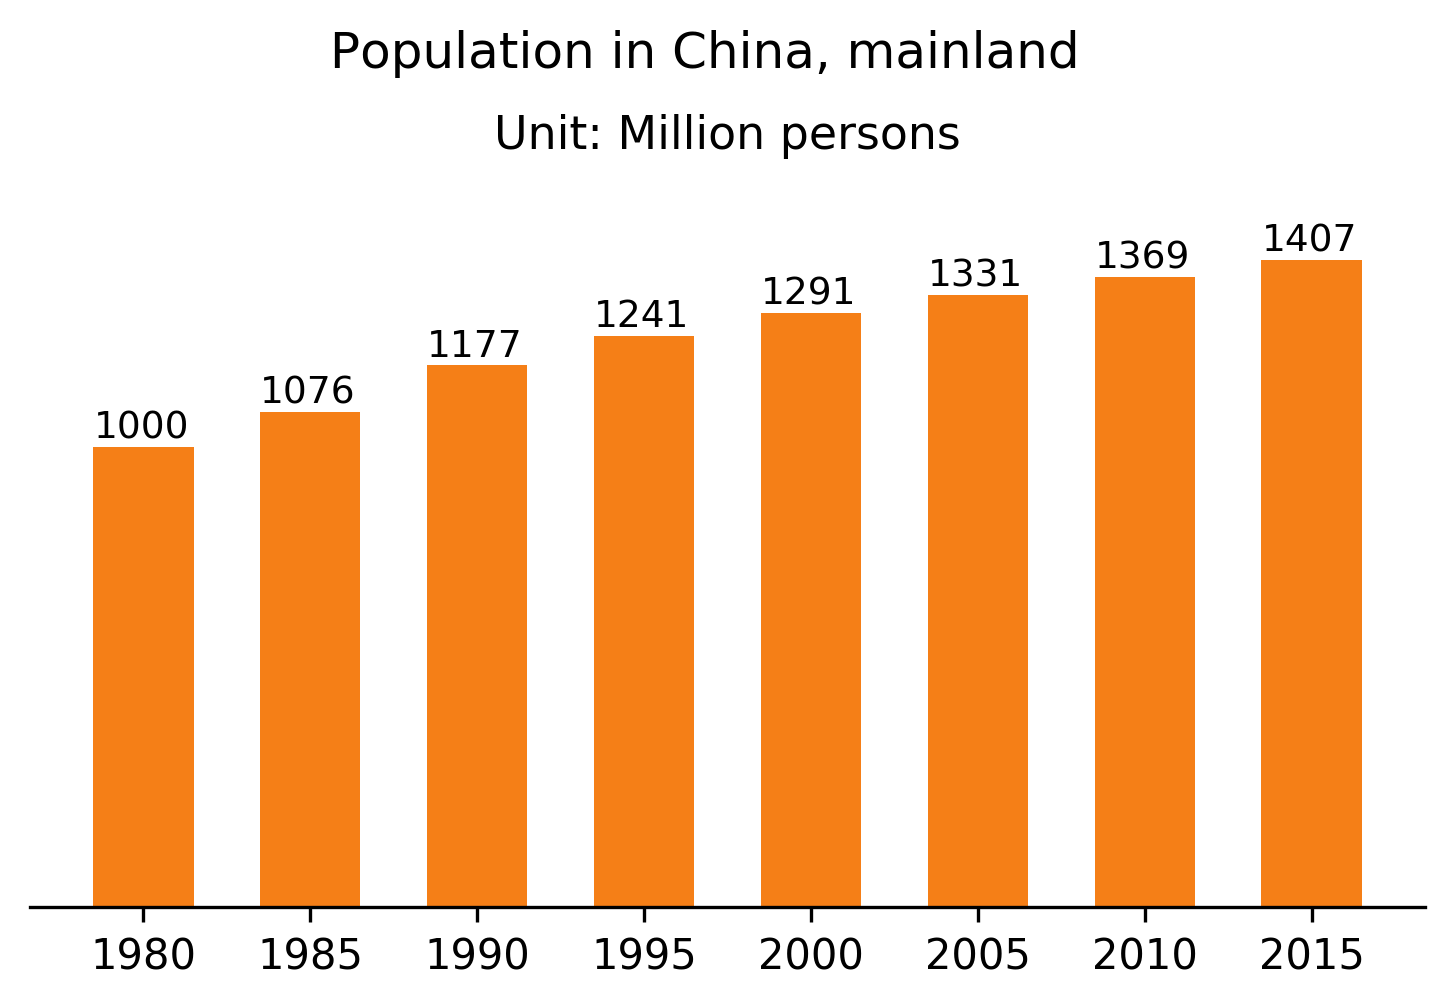

In [73]:
PopulationInAnArea(
    raw_data = DATA, 
    area = 'China, mainland', 
    unit = 'Million persons'
)

## 人口数占世界的比例

In [80]:
def AsPercentageOfWorld(
    raw_data,
    area,
    element = 'Total Population - Both sexes',
    item = 'Population - Est. & Proj.',
):
    df = raw_data.copy()

    # X Values
    X_step = 5
    X_ticks = range(1980, 2015+X_step, X_step)

    df_c = df[
        (df['Area']==area) & 
        (df['Element']==element) & 
        (df['Item']==item) &
        (df['Year'].isin(X_ticks))
    ]
    df_c = df_c[['Year', 'Value']]
    df_c.set_index(['Year'], inplace=True, drop=True)
    display(df_c)

    df_w = df[
        (df['Area']=='World') & 
        (df['Element']==element) & 
        (df['Item']==item) &
        (df['Year'].isin(X_ticks))
    ]
    df_w = df_w[['Year', 'Value']]
    df_w.set_index(['Year'], inplace=True, drop=True)
    display(df_w)

    df_compare = pd.concat([df_c, df_w], axis=1, names=['Year'])
    df_compare.columns = [area, 'World']
    df_compare['Others'] = df_compare['World'] - df_compare[area]
    df_compare['As a percentage of the world'] = df_compare[area] / df_compare['World']

    display(df_compare)

    title = f"Total Population as a percentage of the world in {area}"

    fig = plt.figure(figsize = FIG_size, dpi=DPI)
    plt.suptitle(title, fontsize=TIT_size, y=1.05)

    # Plot
    plt.bar(X_ticks, np.array(df_compare['As a percentage of the world']), width=BAR_wid, color=CLs_2[0])

    ax = plt.gca()

    # Notation
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.annotate('{:.1%}'.format(height), (x, y+height+0.01), fontsize=LEG_size-1)
    
    plt.bar(X_ticks, np.ones(len(X_ticks),np.int), width=BAR_wid, color="#666666", alpha=0.1)

    plt.yticks([])

    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

,Value
Year,
1980,1.0001e+06
1985,1.0756e+06
1990,1.1769e+06
1995,1.2409e+06
2000,1.2906e+06
2005,1.3308e+06
2010,1.3688e+06
2015,1.4068e+06


,Value
Year,
1980,4.4580e+06
1985,4.8709e+06
1990,5.3272e+06
1995,5.7442e+06
2000,6.1435e+06
2005,6.5419e+06
2010,6.9568e+06
2015,7.3798e+06


,"China, mainland",World,Others,As a percentage of the world
Year,,,,
1980,1.0001e+06,4.4580e+06,3.4579e+06,0.2243
1985,1.0756e+06,4.8709e+06,3.7953e+06,0.2208
1990,1.1769e+06,5.3272e+06,4.1503e+06,0.2209
1995,1.2409e+06,5.7442e+06,4.5033e+06,0.2160
2000,1.2906e+06,6.1435e+06,4.8529e+06,0.2101
2005,1.3308e+06,6.5419e+06,5.2111e+06,0.2034
2010,1.3688e+06,6.9568e+06,5.5880e+06,0.1968
2015,1.4068e+06,7.3798e+06,5.9729e+06,0.1906


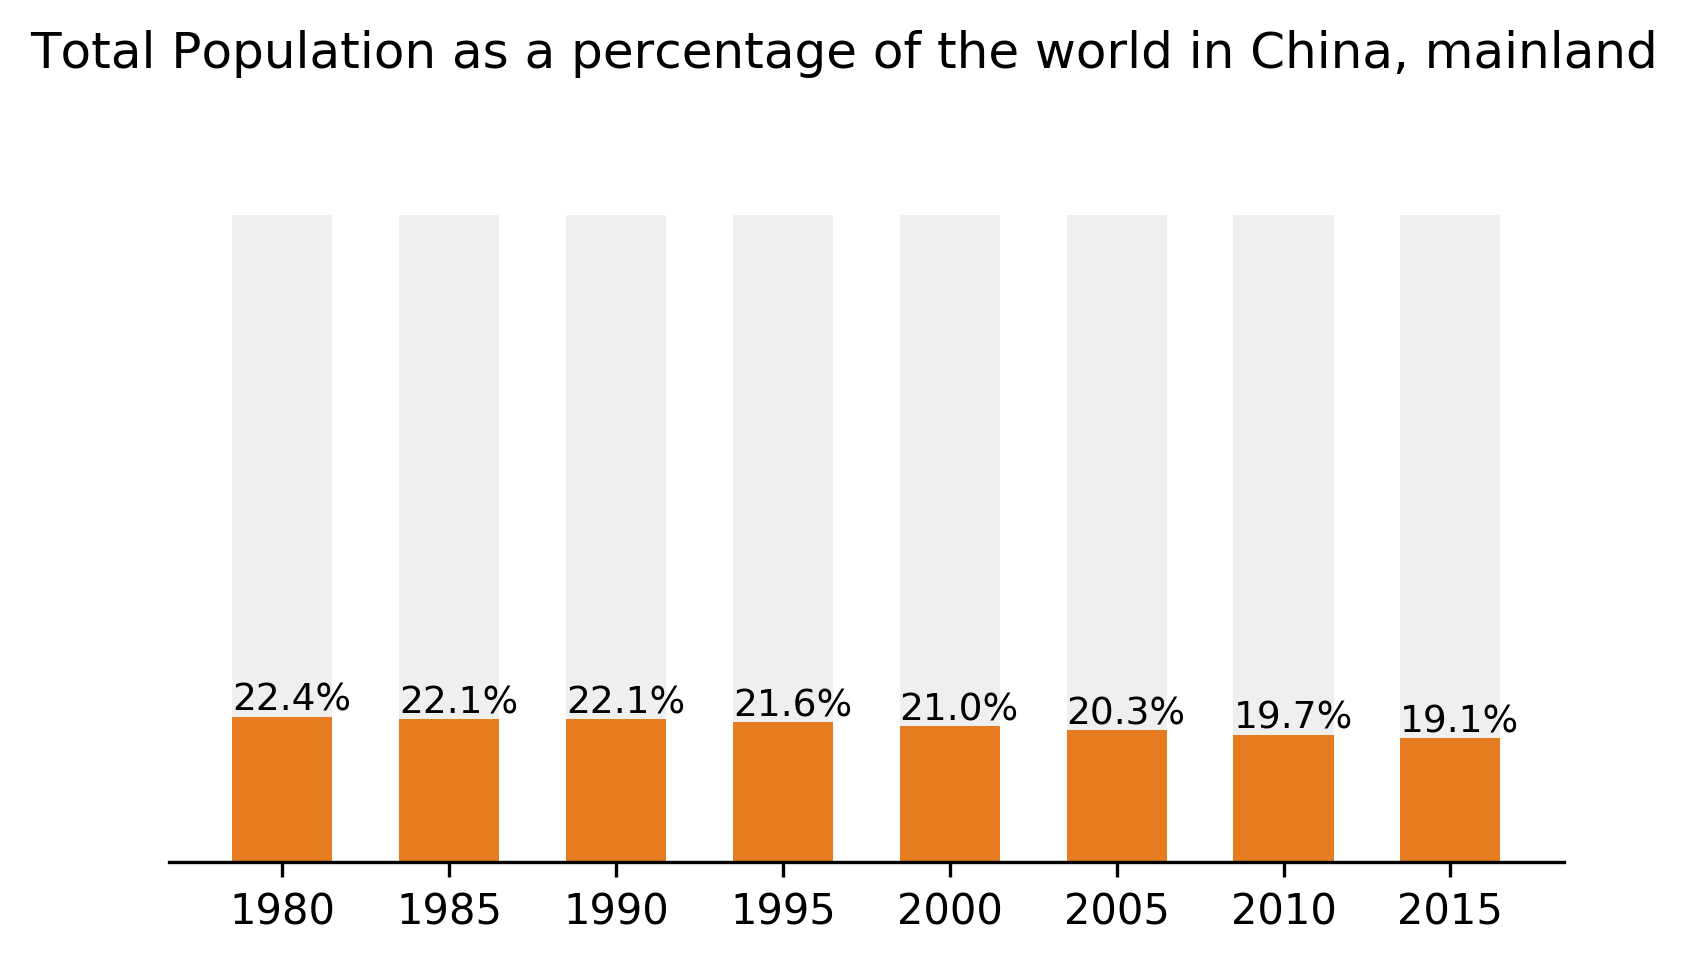

In [81]:
AsPercentageOfWorld(
    raw_data=DATA,
    area='China, mainland',
    element='Total Population - Both sexes',
    item='Population - Est. & Proj.',
)

## 对比世界经合组织

,"China, mainland",OECD Total
Year,,
1980,1000.0892,956.3978
1985,1075.5894,996.7554
1990,1176.8837,1036.6568
1995,1240.9205,1104.0968
2000,1290.5508,1155.2866
2005,1330.7764,1197.0233
2010,1368.8106,1240.7425
2015,1406.8479,1280.0260


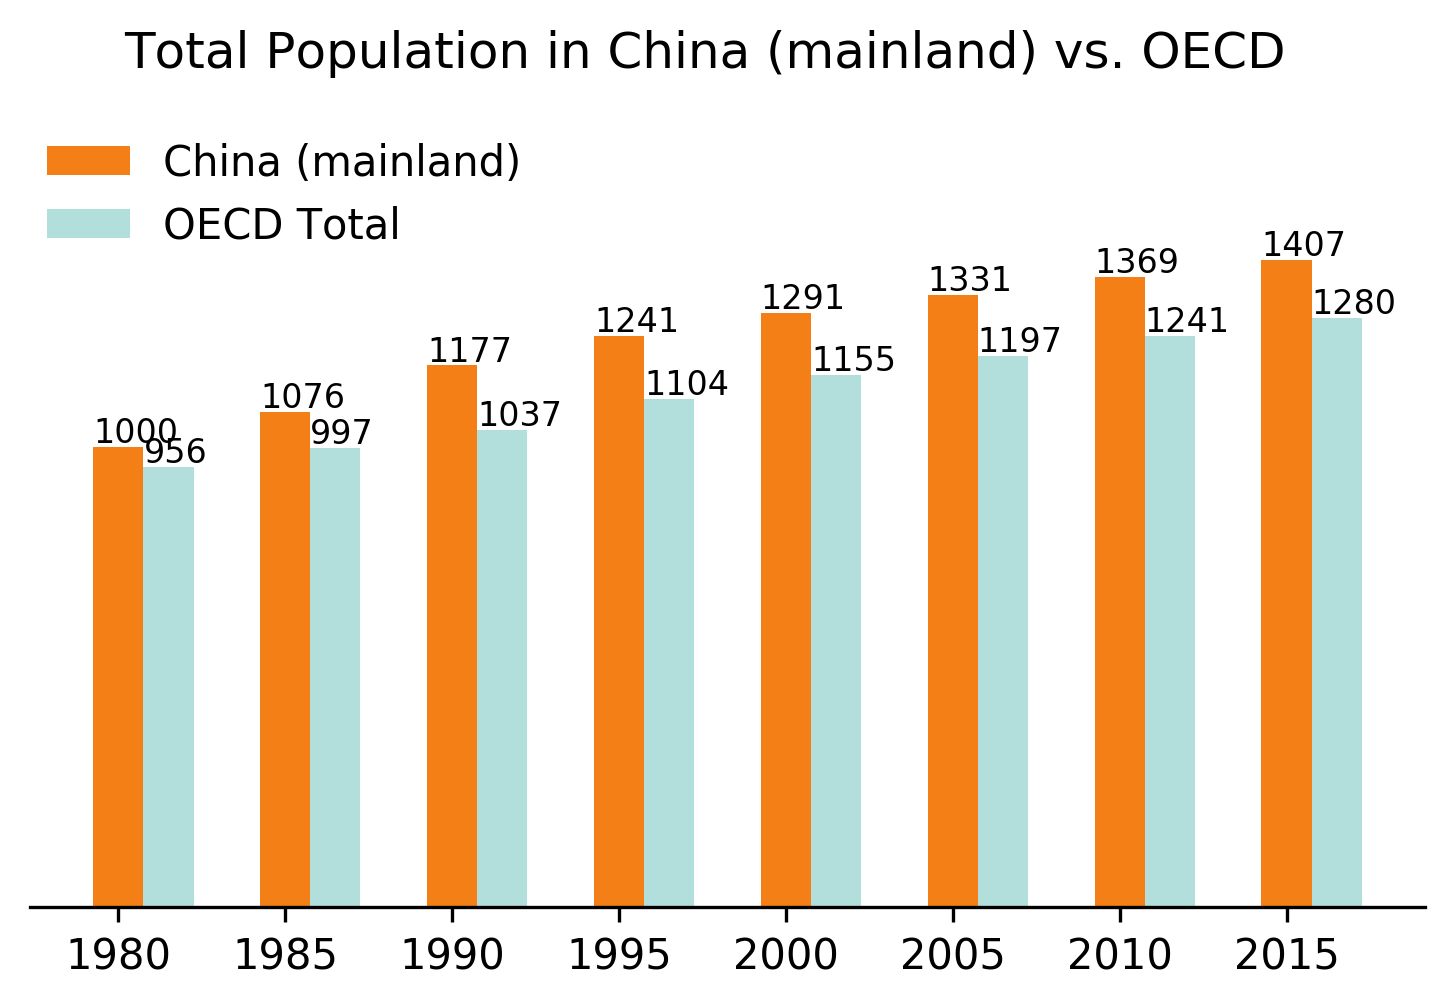

In [94]:
df1 = DF_CN.copy()
df1 = df1[['Year', 'Value']]
df1.set_index(['Year'], inplace=True, drop=True)
df1.columns = ['China, mainland']

df2 = DF_OECD.copy()
df2 = df2[['Total']]
df2.columns = ['OECD Total']

df_12 = pd.concat([df1, df2], axis=1)

df_12 = df_12/1000
# df_12.reset_index(inplace=True)
# df_12.rename(columns={'index': 'Year'}, inplace=True)
# print('Unit: Million persons')
display(df_12)


title = f"Total Population in China (mainland) vs. OECD"

fig = plt.figure(figsize = FIG_size, dpi=DPI)
plt.suptitle(title, fontsize=TIT_size, y=1.1)
# plt.title(sub_title, fontsize=TIT_size-1)

bar_wid = BAR_wid/2

# Plot Y values
plt.bar(X_ticks, np.array(df_12['China, mainland']),  color=CLs_2[0], width=bar_wid)
plt.bar(X_ticks+bar_wid, np.array(df_12['OECD Total']), color=CLs_2[1], width=bar_wid)

ax = plt.gca()

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}'.format(height), (x, y+height+10), fontsize=LEG_size-2)

plt.yticks([])

ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(
    labels=["China (mainland)","OECD Total"], 
    loc='upper left', frameon=False, fontsize=LEG_size,
    bbox_to_anchor=(0,1.15),borderaxespad = 0.,
)